# Compare Changes in the Graph with Current Price Data

Load here the needed libraries and data. Also, filter the data we treat. Finally, choose a time window by computing a column e.g. days, days with hour, etc.

In [1]:
import sys

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from degree_centrality import DegreeCentrality
from current_price_fetcher import CurrentPriceFetcher

Load the edgelist into a pandas frame for preprocessing.

In [2]:
edges = pd.read_csv('../data/csv/edges_deep_link_no_merge.csv')

#prepare human readable time
edges['human_time'] = pd.to_datetime(edges['time'], unit='s').dt.date

edges['human_time_hour'] = pd.to_datetime(edges['time'], unit='s').dt.strftime('%Y-%m-%d %H')

#filter data from to
date_from = pd.to_datetime("2022-4-23").date()
date_to = pd.to_datetime("2022-5-23").date()
frame = edges[(edges['human_time'] >= date_from) & (edges['human_time'] < date_to)]



data = frame.sort_values(by='time')

data.tail(5)

,source,target,score,weight,time,sub,human_time,human_time_hour
195901,monshi633,Wilynesslessness,1,0.5,1.653264e+09,Bitcoin,2022-05-22,2022-05-22 23
195899,monshi633,handsome_latino,1,1.0,1.653264e+09,Bitcoin,2022-05-22,2022-05-22 23
195900,monshi633,PerformanceVarious45,1,1.0,1.653264e+09,Bitcoin,2022-05-22,2022-05-22 23
122787,StepLongjumping,PostingMountainOC,1,1.0,1.653264e+09,Dogecoin,2022-05-22,2022-05-22 23
235621,SoulMechanic,QuantumLeapChicago,1,1.0,1.653264e+09,btc,2022-05-22,2022-05-22 23


## First approach

We want to analyze graph development, i.e. the interactions over time. To do so, we will create a list of cumulitative subsets which correspond to a time window. Each subset is a subset of the next time window, i.e. $day[0] \subset day[1] ...$

In [3]:
def increasing_table_inclusion(df, by='human_time'):
    disj_days = list(df.groupby(by, as_index=False))

    first_day = disj_days[0]
    cumulated = [
        (f'{first_day[0]}:00', #the day to be used on the x axis later
         first_day[1] #the data frame
        )
    ]
    
    for i, day in enumerate(disj_days,start=0):
        if i > 0: #skip first day
            cumulated.append(
                (f'{day[0]}:00', 
                 pd.concat([cumulated[i-1][1], day[1]])
                )
            )
            
    return cumulated

Now, let's create networkx graph instances of these edgelists to analyze them.

In [4]:
Gs = []
for time,cum_days in increasing_table_inclusion(data, by="human_time_hour"):
    Gs.append(
        (time, 
         nx.from_pandas_edgelist(
             cum_days, create_using=nx.MultiDiGraph(), source='source', target='target', 
             edge_attr=['score', 'weight', 'time', 'sub'])
        )
    )

Next, we want to compute the differences between each timeframe. We provide here two possible difference functions. One in percentage and one in absolute value.

In [5]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

def compute_diff_prc(row,col):
    old = row[f'{col}_old']
    new = row[f'{col}_new']
    
    if old > 0:
        return (new / old - 1) * 100
    else:
        return 0
    
def compute_diff_abs(row,col):
    old = row[f'{col}_old']
    new = row[f'{col}_new']
    
    return new - old

def compute_nodes_degree_difference(G1, G2, f=None, cols=None):
    dc = DegreeCentrality()
    df1 = dc.compute_degree_centrality(G1)
    df2 = dc.compute_degree_centrality(G2)
    
    if cols is None:
        cols = { col : [] for col in list(df2.columns)}
        
    if f is None:
        f = compute_diff_prc
    
    diff = pd.DataFrame(cols)
    
    j = df1.join(df2, how='inner', lsuffix='_old', rsuffix='_new')
    
    for col in cols:
        diff[col] = j.apply(lambda row: f(row,col), axis=1)
        
    s = j.reindex(sorted(j.columns), axis=1)
    
    diff.drop(labels=['[deleted]'], axis=0, inplace=True,errors='ignore') #remove deleted posts
    
    
    return diff

Compute the differences.

In [6]:
differences = [ 
    (Gs[i][0], #date
     compute_nodes_degree_difference(Gs[i][1], Gs[i+1][1], f=compute_diff_prc) #frame
    ) 
    for i in range(len(Gs) - 1) 
]

Finally, we can prepare our data for plotting

In [7]:
degrees = [ df.rename(columns={"degree": date} )[date] for date,df in differences ]

plot_data = pd.concat(degrees, axis=1)
#dropzero rows
plot_data = plot_data.loc[~(plot_data==0).all(axis=1)]
#fill nan with 0
plot_data.fillna(0, inplace=True)
plot_data.reset_index(drop=True,inplace=True)

In [8]:
degrees[0]

FamousM1                0.0
3dScanningGuy           0.0
gbhaddie                0.0
vinceforcalifornia    200.0
coinbasesupport         0.0
                      ...  
Tall_Run_2814         100.0
PUMK1ng               100.0
supernormalnorm         0.0
James-the-Bond-one      0.0
Starkgaryen69         200.0
Name: 2022-04-23 00:00, Length: 53, dtype: float64

In [9]:
cols = list(plot_data.columns)
#ax = plot_data.T.plot(figsize=(6, 2),label='_nolegend_')
#plt.xticks(range(0,len(cols)), cols, rotation=90)
#plt.show()

In [10]:
plot_data.to_csv("comp_data.csv")

In [14]:
plot_data = pd.read_csv('comp_data.csv', index_col=0)
plot_data

,2022-04-23 00:00,2022-04-23 01:00,2022-04-23 02:00,2022-04-23 03:00,2022-04-23 04:00,2022-04-23 05:00,2022-04-23 06:00,2022-04-23 07:00,2022-04-23 08:00,2022-04-23 09:00,2022-04-23 10:00,2022-04-23 11:00,2022-04-23 12:00,2022-04-23 13:00,2022-04-23 14:00,2022-04-23 15:00,2022-04-23 16:00,2022-04-23 17:00,2022-04-23 18:00,2022-04-23 19:00,2022-04-23 20:00,2022-04-23 21:00,2022-04-23 22:00,2022-04-23 23:00,2022-04-24 00:00,2022-04-24 01:00,2022-04-24 02:00,2022-04-24 03:00,2022-04-24 04:00,2022-04-24 05:00,2022-04-24 06:00,2022-04-24 07:00,2022-04-24 08:00,2022-04-24 09:00,2022-04-24 10:00,2022-04-24 11:00,2022-04-24 12:00,2022-04-24 13:00,2022-04-24 14:00,2022-04-24 15:00,2022-04-24 16:00,2022-04-24 17:00,2022-04-24 18:00,2022-04-24 19:00,2022-04-24 20:00,2022-04-24 21:00,2022-04-24 22:00,2022-04-24 23:00,2022-04-25 00:00,2022-04-25 01:00,2022-04-25 02:00,2022-04-25 03:00,2022-04-25 04:00,2022-04-25 05:00,2022-04-25 06:00,2022-04-25 07:00,2022-04-25 08:00,2022-04-25 09:00,2022-04-25 10:00,2022-04-25 11:00,2022-04-25 12:00,2022-04-25 13:00,2022-04-25 14:00,2022-04-25 15:00,2022-04-25 16:00,2022-04-25 17:00,2022-04-25 18:00,2022-04-25 19:00,2022-04-25 20:00,2022-04-25 21:00,2022-04-25 22:00,2022-04-25 23:00,2022-04-26 00:00,2022-04-26 01:00,2022-04-26 02:00,2022-04-26 03:00,2022-04-26 04:00,2022-04-26 05:00,2022-04-26 06:00,2022-04-26 07:00,2022-04-26 08:00,2022-04-26 09:00,2022-04-26 10:00,2022-04-26 11:00,2022-04-26 12:00,2022-04-26 13:00,2022-04-26 14:00,2022-04-26 15:00,2022-04-26 16:00,2022-04-26 17:00,2022-04-26 18:00,2022-04-26 19:00,2022-04-26 20:00,2022-04-26 21:00,2022-04-26 22:00,2022-04-26 23:00,2022-04-27 00:00,2022-04-27 01:00,2022-04-27 02:00,2022-04-27 03:00,2022-04-27 04:00,2022-04-27 05:00,2022-04-27 06:00,2022-04-27 07:00,2022-04-27 08:00,2022-04-27 09:00,2022-04-27 10:00,2022-04-27 11:00,2022-04-27 12:00,2022-04-27 13:00,2022-04-27 14:00,2022-04-27 15:00,2022-04-27 16:00,2022-04-27 17:00,2022-04-27 18:00,2022-04-27 19:00,2022-04-27 20:00,2022-04-27 21:00,2022-04-27 22:00,2022-04-27 23:00,2022-04-28 00:00,2022-04-28 01:00,2022-04-28 02:00,2022-04-28 03:00,2022-04-28 04:00,2022-04-28 05:00,2022-04-28 06:00,2022-04-28 07:00,2022-04-28 08:00,2022-04-28 09:00,2022-04-28 10:00,2022-04-28 11:00,2022-04-28 12:00,2022-04-28 13:00,2022-04-28 14:00,2022-04-28 15:00,2022-04-28 16:00,2022-04-28 17:00,2022-04-28 18:00,2022-04-28 19:00,2022-04-28 20:00,2022-04-28 21:00,2022-04-28 22:00,2022-04-28 23:00,2022-04-29 00:00,2022-04-29 01:00,2022-04-29 02:00,2022-04-29 03:00,2022-04-29 04:00,2022-04-29 05:00,2022-04-29 06:00,2022-04-29 07:00,2022-04-29 08:00,2022-04-29 09:00,2022-04-29 10:00,2022-04-29 11:00,2022-04-29 12:00,2022-04-29 13:00,2022-04-29 14:00,2022-04-29 15:00,2022-04-29 16:00,2022-04-29 17:00,2022-04-29 18:00,2022-04-29 19:00,2022-04-29 20:00,2022-04-29 21:00,2022-04-29 22:00,2022-04-29 23:00,2022-04-30 00:00,2022-04-30 01:00,2022-04-30 02:00,2022-04-30 03:00,2022-04-30 04:00,2022-04-30 05:00,2022-04-30 06:00,2022-04-30 07:00,2022-04-30 08:00,2022-04-30 09:00,2022-04-30 10:00,2022-04-30 11:00,2022-04-30 12:00,2022-04-30 13:00,2022-04-30 14:00,2022-04-30 15:00,2022-04-30 16:00,2022-04-30 17:00,2022-04-30 18:00,2022-04-30 19:00,2022-04-30 20:00,2022-04-30 21:00,2022-04-30 22:00,2022-04-30 23:00,2022-05-01 00:00,2022-05-01 01:00,2022-05-01 02:00,2022-05-01 03:00,2022-05-01 04:00,2022-05-01 05:00,2022-05-01 06:00,2022-05-01 07:00,2022-05-01 08:00,2022-05-01 09:00,2022-05-01 10:00,2022-05-01 11:00,2022-05-01 12:00,2022-05-01 13:00,2022-05-01 14:00,2022-05-01 15:00,2022-05-01 16:00,2022-05-01 17:00,2022-05-01 18:00,2022-05-01 19:00,2022-05-01 20:00,2022-05-01 21:00,2022-05-01 22:00,2022-05-01 23:00,2022-05-02 00:00,2022-05-02 01:00,2022-05-02 02:00,2022-05-02 03:00,2022-05-02 04:00,2022-05-02 05:00,2022-05-02 06:00,2022-05-02 07:00,2022-05-02 08:00,2022-05-02 09:00,2022-05-02 10:00,2022-05-02 11:00,2022-05-02 12:00,2022-05-02 13:00,2022-05-02 14:00,2022-05-02 15:00,2022-05-02 16:00,2022-05-02 17:00,2022-05-02 18:00,2022

Let's sum up each row and see how it develops; each row represents one user, each column represents one time window.

<AxesSubplot:>

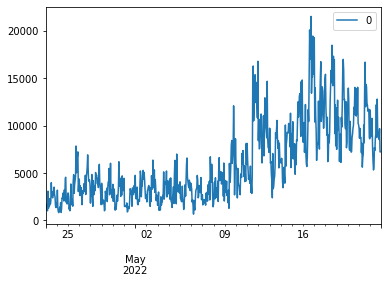

In [16]:
sums = pd.DataFrame(plot_data.apply(lambda col: sum(col), axis=0))
sums.index = pd.to_datetime(sums.index)
sums.plot()

Compute moving average.

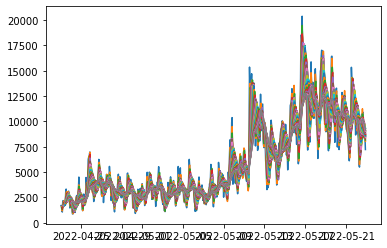

In [17]:
ma_windows = range(2,30)
for i in ma_windows:
    sums[f'ma_{i}'] = sums[0].rolling(i).mean()
    plt.plot(sums[f'ma_{i}'])

#plt.savefig('plots/sums_ma.pdf')
#plt.show()


### Compare with price

Load the price data and preprocess.

In [18]:
df = pd.read_csv('../data/price/BTC-USD-2022-04-01.csv')

df['human_time'] = pd.to_datetime(df['unix'], unit='s').dt.date

df['human_time_hour'] = pd.to_datetime(df['unix'], unit='s').dt.strftime('%Y-%m-%d %H')

frame = df[(df['human_time'] >= date_from) & (df['human_time'] < date_to)]

<AxesSubplot:>

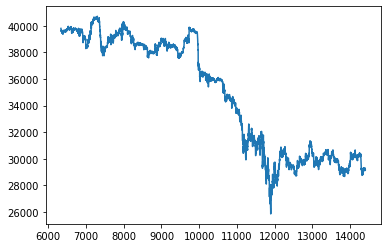

In [19]:
frame['close'].plot()

Compute moving average also for .

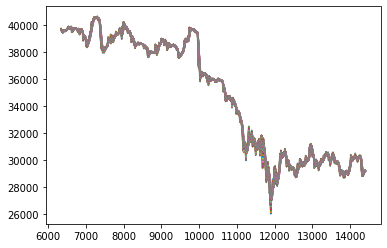

In [20]:
closes = pd.DataFrame({})
f = frame['close'] #column to use


for i in ma_windows:
    closes[f'ma_{i}'] = f.rolling(i*2).mean()
    plt.plot(closes[f'ma_{i}'])
    
plt.show()

Plot price over set of moving windows of sums.

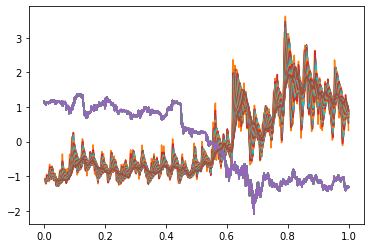

In [21]:
price = frame['close'].copy()
for i in ma_windows:
    d = sums[f'ma_{i}']
    x1 = np.linspace(0, 1, len(price))
    x2 = np.linspace(0, 1, len(d))
    
    normalized_d=(d-d.mean())/d.std()
    normalized_price=(price-price.mean())/price.std()
    plt.plot(x1, normalized_price)
    plt.plot(x2, normalized_d)

In [22]:
from scipy.stats import pearsonr

def get_correlation(vals):
    return pearsonr(vals, normalized_sums)[0]




normalized_ds = (sums-sums.mean())/sums.std()
normalized_prices = (closes-closes.mean())/closes.std()

#i = -1
#
#for d in normalized_ds.columns:
#    for p in normalized_prices.columns:
#        f = pd.DataFrame(normalized_prices[p].rolling(window=len(normalized_ds[d])).apply(get_correlation))
#        #plot = f.plot()
#        #fig = plot.get_figure()
#        #fig.savefig(f"plots/corrs/{i}.pdf")
#        i += 1
#



# Next try, spearman

In [23]:
price = frame.copy()

#resample data first
price['dt'] = pd.to_datetime(price['unix'], unit='s')
price.set_index('dt', inplace=True)

close = price['close']


time_delta_columns = (price.iloc[[1]].unix.values - price.iloc[[0]].unix.values)[0]
resample_freq = int((time_delta_columns*len(close))/len(normalized_ds))

resample_freq = 60

r_close = close.resample(f'{resample_freq}min').mean()

#normalize
r_close=(r_close-r_close.mean())/r_close.std()

r_close

dt
2022-04-23 00:00:00    1.135806
2022-04-23 01:00:00    1.122461
2022-04-23 02:00:00    1.098506
2022-04-23 03:00:00    1.091269
2022-04-23 04:00:00    1.092115
                         ...   
2022-05-20 19:00:00   -1.330089
2022-05-20 20:00:00   -1.302947
2022-05-20 21:00:00   -1.304360
2022-05-20 22:00:00   -1.305845
2022-05-20 23:00:00   -1.296317
Freq: 60T, Name: close, Length: 672, dtype: float64

In [24]:
pd.set_option('display.max_rows', 450)
normalized_ds.index.to_list()
i = 0
for g in r_close.index.to_list():
    #i1=g.strftime("%m/%d/%Y %H:%M:%S")
    #i2=normalized_ds[i].strftime("%m/%d/%Y %H:%M:%S")
    #print(i1,i2)
    pass
    
s1 = set(r_close.index.to_list())
s2= set(normalized_ds.index.to_list())

#
#r_close.join(normalized_ds)
c = pd.DataFrame(r_close).join(pd.DataFrame(normalized_ds.iloc[:,0]), how='inner')

<AxesSubplot:>

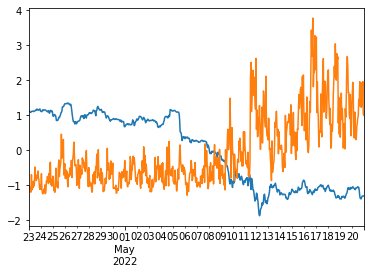

In [25]:
c.iloc[:,0].plot()
c.iloc[:,1].plot()

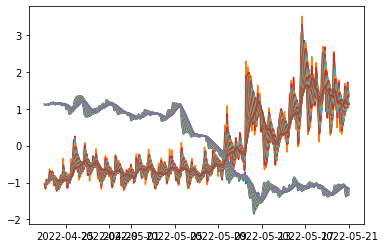

In [26]:
#compute moving averages


mas_p = pd.DataFrame({})
mas_a = pd.DataFrame({})
for i in ma_windows:
    price = c.iloc[:,0].rolling(i).mean()
    mas_p[f'ma_{i}'] = price
    plt.plot(mas_p[f'ma_{i}'])
    
    activity = c.iloc[:,1].rolling(i).mean()
    mas_a[f'ma_{i}'] = activity
    plt.plot(mas_a[f'ma_{i}'])

In [27]:
mas_a.index

DatetimeIndex(['2022-04-23 00:00:00', '2022-04-23 01:00:00',
               '2022-04-23 02:00:00', '2022-04-23 03:00:00',
               '2022-04-23 04:00:00', '2022-04-23 05:00:00',
               '2022-04-23 06:00:00', '2022-04-23 07:00:00',
               '2022-04-23 08:00:00', '2022-04-23 09:00:00',
               ...
               '2022-05-20 14:00:00', '2022-05-20 15:00:00',
               '2022-05-20 16:00:00', '2022-05-20 17:00:00',
               '2022-05-20 18:00:00', '2022-05-20 19:00:00',
               '2022-05-20 20:00:00', '2022-05-20 21:00:00',
               '2022-05-20 22:00:00', '2022-05-20 23:00:00'],
              dtype='datetime64[ns]', length=672, freq=None)

spearman coefficients:


array([[ 1.       , -0.7982054],
       [-0.7982054,  1.       ]])

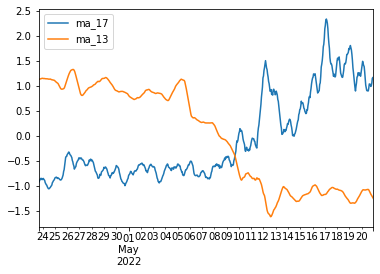

In [31]:
import seaborn as sns

fr = '2022-04-23 00:00:00'
to = '2022-05-23 00:00:00'

ma = mas_a.loc[fr:to]
mp = mas_p.loc[fr:to]

r = []

for p in mp:
    for a in ma:
        c = pd.DataFrame(ma[a]).join(pd.DataFrame(mp[p]), how='inner', lsuffix='_activity', rsuffix='_price')
        c.dropna(inplace=True)
        s = c.corr(method="spearman").values
        v = abs(s[0][1]) + abs(s[1][0])
        r.append((v,s,c))

sort = sorted(r, key=lambda tup: -tup[0])

print("spearman coefficients:")
sort[0][2].plot()
sort[0][1]

pearson coefficients:


array([[ 1.        , -0.87206723],
       [-0.87206723,  1.        ]])

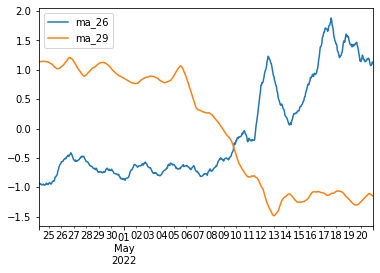

In [32]:
# Pearson again
ma = mas_a.loc[fr:to]
mp = mas_p.loc[fr:to]

r = []

for p in mp:
    for a in ma:
        c = pd.DataFrame(ma[a]).join(pd.DataFrame(mp[p]), how='inner', lsuffix='_activity', rsuffix='_price')
        c.dropna(inplace=True)
        s = c.corr().values
        v = abs(s[0][1]) + abs(s[1][0])
        r.append((v,s,c))

sort = sorted(r, key=lambda tup: -tup[0])

print("pearson coefficients:")
sort[0][2].plot()
sort[0][1]

## Try HSIC


HSIC:


0.11707828753982771

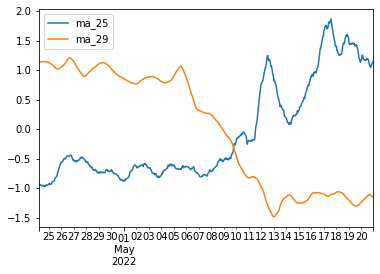

In [33]:
import numpy
from hsic import dHSIC


r=[]
for p in mp:
    for a in ma:
        c = pd.DataFrame(ma[a]).join(pd.DataFrame(mp[p]), how='inner', lsuffix='_activity', rsuffix='_price')
        c.dropna(inplace=True)
        
        x = np.array(c.iloc[:,0].to_numpy())
        y = np.array(c.iloc[:,1].to_numpy())
        
        v = dHSIC(x, y)
        r.append((v,c))


sort = sorted(r, key=lambda tup: -tup[0])

print("HSIC:")
sort[0][1].plot()
sort[0][0]